In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn import metrics
from scipy.stats import chi2_contingency
import itertools
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

In [ ]:
store_hierarchy = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Case Study Data.xlsx", sheet_name="Store Hierarchy")
store_sales_data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Case Study Data.xlsx", sheet_name="Store Sales Data")

df = pd.merge(store_sales_data, store_hierarchy, on="StoreNum", how="left")

In [ ]:
df.shape

(98281, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98281 entries, 0 to 98280
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Year-Week          98281 non-null  int64         
 1   StoreNum           98281 non-null  int64         
 2   Category           98281 non-null  int64         
 3   Sales              98281 non-null  float64       
 4   Units              98281 non-null  int64         
 5   Profit             98281 non-null  float64       
 6   Open Date          98281 non-null  datetime64[ns]
 7   State Province     98281 non-null  int64         
 8   Market             98281 non-null  int64         
 9   Region             50129 non-null  float64       
 10  Locality Code      95319 non-null  float64       
 11  Climate Code       93153 non-null  float64       
 12  Pharmacy_IND       98078 non-null  object        
 13  Pickup_IND         98281 non-null  object        
 14  SFS_IN

In [ ]:
df.describe()

,Year-Week,StoreNum,Category,Sales,Units,Profit,Open Date,State Province,Market,Region,Locality Code,Climate Code,INCOME_CD,ETHNICITY_CD
count,98281.000000,98281.000000,98281.000000,9.828100e+04,98281.000000,9.828100e+04,98281,98281.000000,98281.000000,50129.000000,95319.000000,93153.000000,95319.000000,95319.000000
mean,202268.678076,47.438121,15.167591,6.232685e+04,1449.670221,2.355269e+04,1987-07-25 04:48:42.021550400,33.479665,99.914460,408.678529,1.980319,2.185383,2.078945,2.058393
min,202149.000000,1.000000,1.000000,-1.601365e+05,-232.000000,-1.283778e+05,1980-01-01 00:00:00,1.000000,93.000000,401.000000,1.000000,1.000000,1.000000,1.000000
25%,202223.000000,24.000000,3.000000,4.452480e+03,136.000000,1.093216e+03,1980-02-01 00:00:00,6.000000,96.000000,407.000000,2.000000,2.000000,2.000000,2.000000
50%,202249.000000,47.000000,7.000000,2.635493e+04,780.000000,9.129925e+03,1980-02-01 00:00:00,46.000000,101.000000,408.000000,2.000000,2.000000,2.000000,2.000000
75%,202323.000000,71.000000,35.000000,6.878149e+04,1770.000000,2.692642e+04,1993-08-11 00:00:00,46.000000,102.000000,413.000000,2.000000,3.000000,2.000000,2.000000
max,202416.000000,96.000000,90.000000,8.476579e+06,143839.000000,3.008048e+06,2018-08-11 00:00:00,64.000000,108.000000,416.000000,3.000000,3.000000,3.000000,3.000000
std,55.401413,27.356669,17.332911,1.725339e+05,3122.311596,6.588800e+04,NaN,23.436404,4.928225,4.387042,0.521240,0.668714,0.607234,0.640923


In [ ]:
df.drop(columns=["Year-Week"],axis=1,inplace=True)
df.drop(columns=["Region"],axis=1,inplace=True)
df.drop(columns=["Open Date"],axis=1,inplace=True)

numerical_columns = ["Sales", "Profit", "Units "]
categorical_columns = ['Category', 'State Province', 'Market', 'Locality Code', 'Climate Code', 'Pharmacy_IND', 'Pickup_IND', 'SFS_IND', 'COMP_IND', 'College_STORE_IND', 'INCOME_CD', 'ETHNICITY_CD']

# Handle missing values
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")
df[numerical_columns] = num_imputer.fit_transform(df[numerical_columns])
df[categorical_columns] = cat_imputer.fit_transform(df[categorical_columns])

In [ ]:
df.isnull().sum()

,0
StoreNum,0
Category,0
Sales,0
Units,0
Profit,0
State Province,0
Market,0
Locality Code,0
Climate Code,0
Pharmacy_IND,0


In [ ]:
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(df[categorical_columns])

In [ ]:
scaler = StandardScaler()
scaled_nums = scaler.fit_transform(df[numerical_columns])
# Combine scaled numerical and encoded categorical variables
segmentation_data = np.hstack([scaled_nums, encoded_cats])

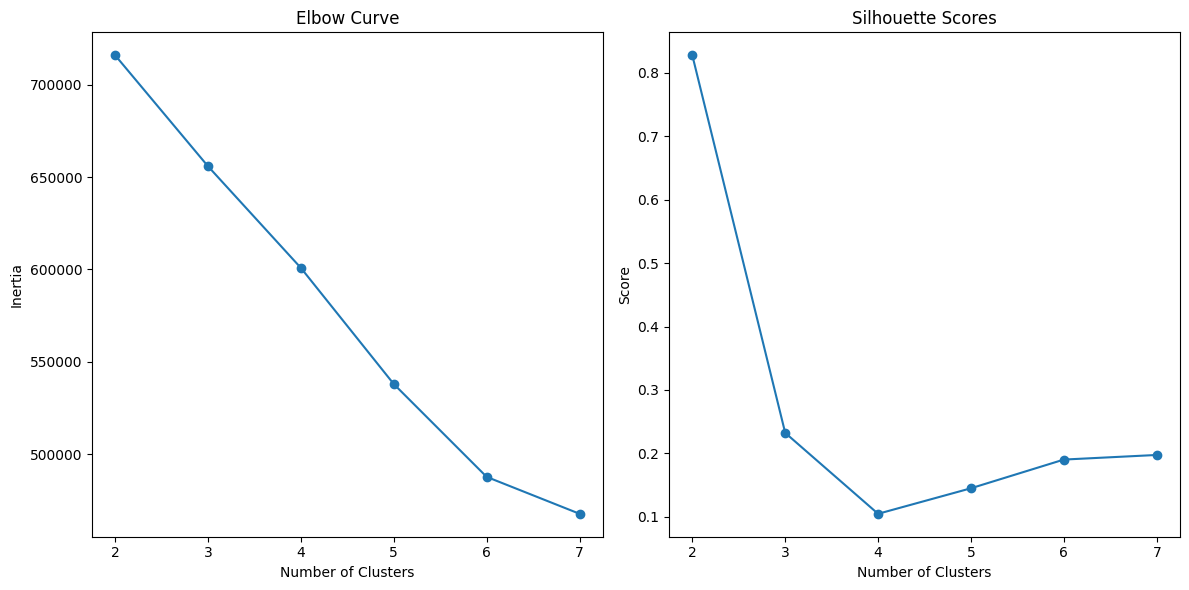

In [ ]:
inertia = []
silhouette_scores = []
cluster_range = range(2, 8)  # Restrict segments to 7 max as per guideline
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(segmentation_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(segmentation_data, kmeans.labels_))

# Plot the elbow curve and silhouette scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

In [ ]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df["Segment"] = kmeans.fit_predict(segmentation_data)

In [ ]:
segment_counts = df['Segment'].value_counts(normalize=True)
small_segments = segment_counts[segment_counts < 0.05].index  # Segments with less than 5% of stores
small_segments

Index([2], dtype='int32', name='Segment')

In [ ]:
centroids = kmeans.cluster_centers_
for small_segment in small_segments:
    distances = np.linalg.norm(centroids - centroids[small_segment], axis=1)
    distances[small_segment] = np.inf
    closest_segment = np.argmin(distances)
    df.loc[df['Segment'] == small_segment, 'Segment'] = closest_segment

new_segment_counts = df['Segment'].value_counts(normalize=True)
new_segment_counts

,proportion
Segment,
1,0.675929
3,0.265718
0,0.058353


In [ ]:
df["Segment"].value_counts()

,count
Segment,
1,66431
3,26115
0,5735


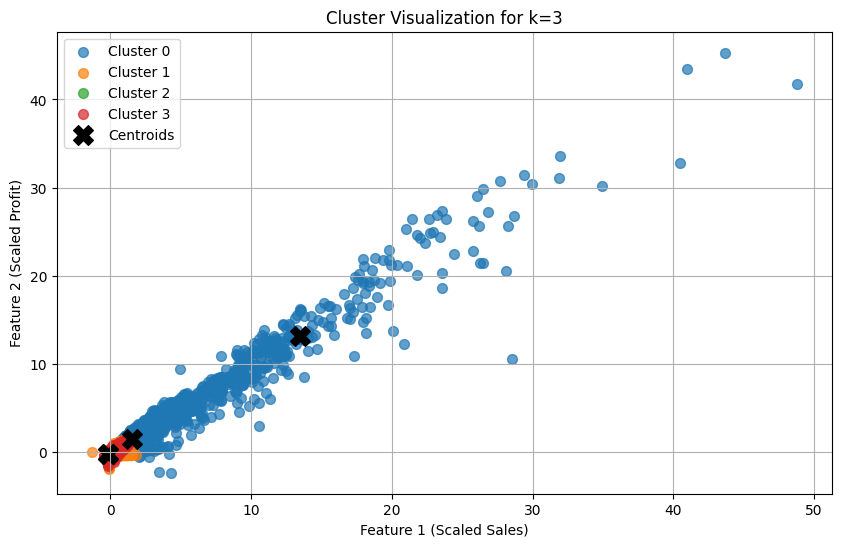

In [ ]:
clusters = df["Segment"]
x_feature = segmentation_data[:, 0]  # First feature ("Sales")
y_feature = segmentation_data[:, 1]  # Second feature ("Unit")

plt.figure(figsize=(10, 6))
for cluster in range(optimal_clusters):
    plt.scatter(
        x_feature[clusters == cluster],
        y_feature[clusters == cluster],
        label=f"Cluster {cluster}",
        s=50,  # Marker size
        alpha=0.7  # Transparency
    )

centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    s=200,
    c="black",
    marker="X",
    label="Centroids"
)

plt.title("Cluster Visualization for k=3")
plt.xlabel("Feature 1 (Scaled Sales)")
plt.ylabel("Feature 2 (Scaled Profit)")
plt.legend()
plt.grid(True)
plt.show()


<Axes: xlabel='Segment', ylabel='count'>

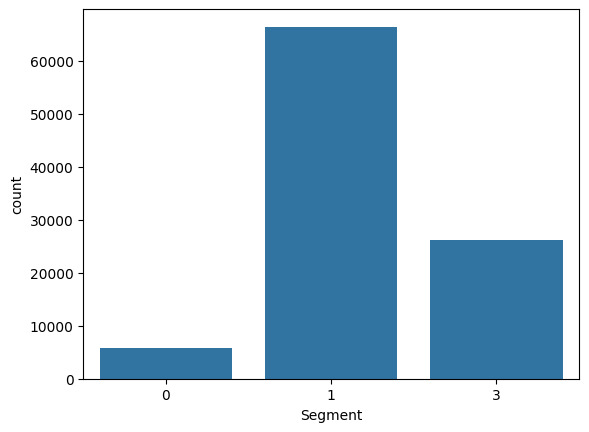

In [ ]:
#Visualization
sns.countplot(x='Segment', data=df)

In [ ]:
# for c in df.drop(['Segment'],axis=1):
#     grid= sns.FacetGrid(df, col='Segment')
#     grid= grid.map(plt.hist, c)
# plt.show()

In [ ]:
df.to_csv("Clustered_Customer_Data.csv")

In [ ]:
#df = df.drop(columns=["Year-Week"])
#df = df.drop(columns=["Open Date"])
categorical_columns = ["Pharmacy_IND", "Pickup_IND", "SFS_IND", "COMP_IND", "College_STORE_IND"]
X = df.drop(columns=["Segment"])
y = df["Segment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_columns),
        ('num', SimpleImputer(strategy='mean'), X.columns.difference(categorical_columns))
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5))  # Adjust max_depth if needed
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
#Confusion_Matrix
print(metrics.confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

[[ 1429   263    28]
 [   58 19872     0]
 [   18   319  7498]]
Accuracy Score: 0.976733932508055

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.89      1720
           1       0.97      1.00      0.98     19930
           3       1.00      0.96      0.98      7835

    accuracy                           0.98     29485
   macro avg       0.97      0.93      0.95     29485
weighted avg       0.98      0.98      0.98     29485



**1) Which stores are the most critical drivers of overall revenue and customer engagement?**

In [ ]:
df1 = df.copy()
aggregated_data = df.groupby('StoreNum').agg({'Sales': 'sum',
                                              'Profit': 'sum',
                                              'Units ': 'sum'}).reset_index()


aggregated_data.rename(columns={'Sales': 'Total Sales','Profit': 'Total Profit','Units ': 'Total Units Sold'}, inplace=True)

In [ ]:
aggregated_data['Revenue Contribution (%)'] = (aggregated_data['Total Sales'] / aggregated_data['Total Sales'].sum()) * 100
aggregated_data['Profit Contribution (%)'] = (aggregated_data['Total Profit'] / aggregated_data['Total Profit'].sum()) * 100

top_revenue_stores = aggregated_data.sort_values(by='Total Sales', ascending=False).head(10)
top_profit_stores = aggregated_data.sort_values(by='Total Profit', ascending=False).head(10)

top_engagement_stores = aggregated_data.sort_values(by='Total Units Sold', ascending=False).head(10)

In [ ]:
aggregated_data.head()

,StoreNum,Total Sales,Total Profit,Total Units Sold,Revenue Contribution (%),Profit Contribution (%)
0,1,2.564491e+07,9.737096e+06,791358.0,0.418655,0.420649
1,2,2.590470e+08,1.041184e+08,5194027.0,4.228962,4.497979
2,3,3.267491e+07,1.226861e+07,826069.0,0.533420,0.530011
3,4,3.452026e+07,1.387438e+07,997542.0,0.563546,0.599382
4,5,7.886991e+07,3.127801e+07,2053927.0,1.287557,1.351229


In [ ]:
# Top Stores Table
top_stores = aggregated_data[['StoreNum', 'Total Sales', 'Total Profit', 'Total Units Sold', 'Revenue Contribution (%)']].sort_values(
    by='Total Sales', ascending=False).head(10)
print("Top 10 Revenue-Contributing Stores:")
top_stores

Top 10 Revenue-Contributing Stores:


,StoreNum,Total Sales,Total Profit,Total Units Sold,Revenue Contribution (%)
56,57,9.620189e+08,3.582484e+08,18055255.0,15.705033
19,20,4.017005e+08,1.386491e+08,6302941.0,6.557792
1,2,2.590470e+08,1.041184e+08,5194027.0,4.228962
64,65,2.541535e+08,9.435414e+07,4646600.0,4.149076
77,78,1.752104e+08,6.896358e+07,3454114.0,2.860324
55,56,1.252802e+08,4.826597e+07,2631315.0,2.045208
80,81,1.061875e+08,4.169595e+07,2277867.0,1.733518
16,17,1.023421e+08,4.147414e+07,2300731.0,1.670744
10,11,9.312666e+07,3.629716e+07,2191532.0,1.520300
14,15,9.297647e+07,3.397558e+07,1823038.0,1.517848


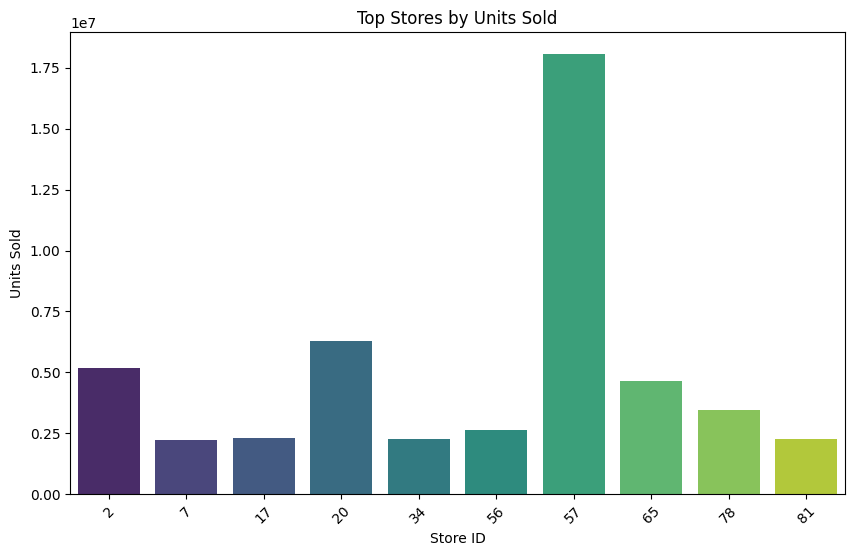

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_engagement_stores, x='StoreNum', y='Total Units Sold', palette='viridis')
plt.title("Top Stores by Units Sold")
plt.xlabel("Store ID")
plt.ylabel("Units Sold")
plt.xticks(rotation=45)
plt.show()

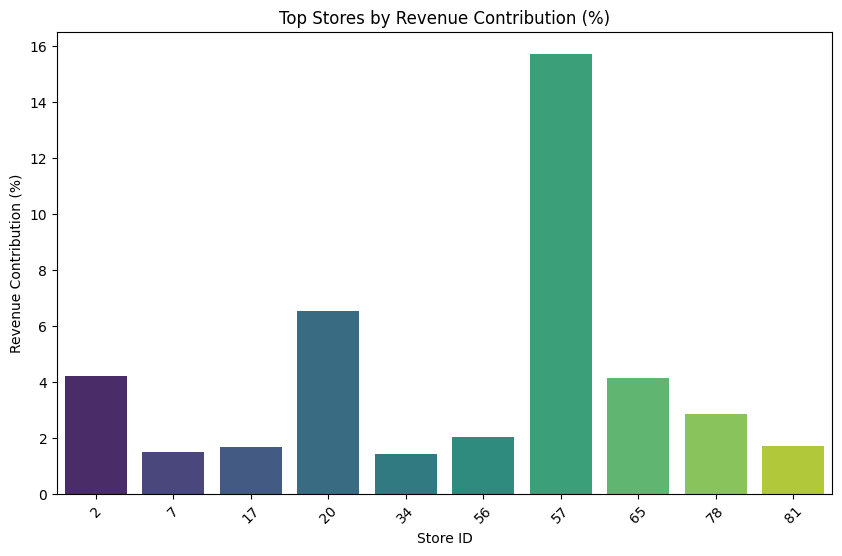

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_engagement_stores, x='StoreNum', y='Revenue Contribution (%)', palette='viridis')
plt.title("Top Stores by Revenue Contribution (%)")
plt.xlabel("Store ID")
plt.ylabel("Revenue Contribution (%)")
plt.xticks(rotation=45)
plt.show()

**2) What are the demographic characteristics of high-value stores that contribute significantly to profitability?**

In [ ]:
top_percentile = 0.90
high_value_threshold = df1['Profit'].quantile(top_percentile)
high_value_stores = df1[df1['Profit'] >= high_value_threshold]

demographic_columns = ['State Province', 'Market', 'Climate Code', 'Pharmacy_IND',
                       'Pickup_IND', 'SFS_IND', 'COMP_IND', 'College_STORE_IND',
                       'INCOME_CD', 'ETHNICITY_CD']

high_value_summary = high_value_stores[demographic_columns].describe(include='all')
other_stores = df1[df1['Profit'] < high_value_threshold]
other_stores_summary = other_stores[demographic_columns].describe(include='all')

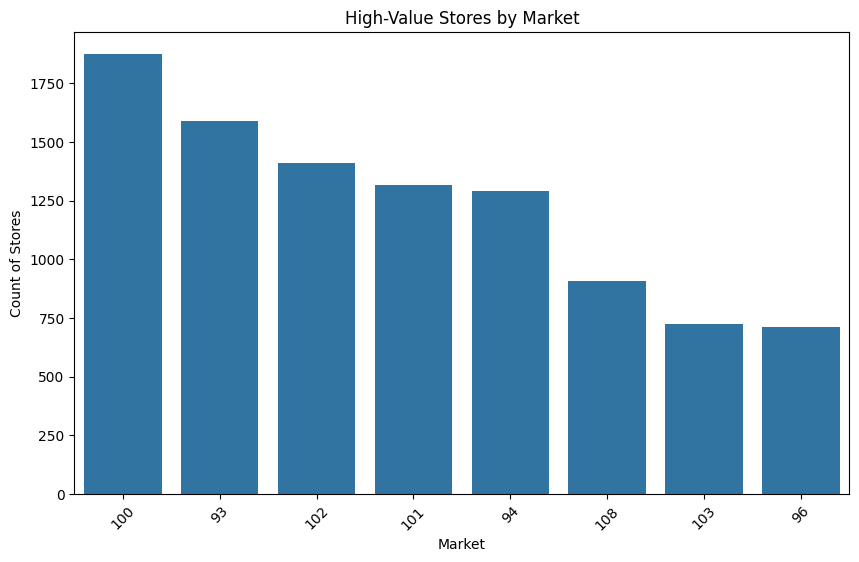

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=high_value_stores, x='Market', order=high_value_stores['Market'].value_counts().index)
plt.title("High-Value Stores by Market")
plt.xlabel("Market")
plt.ylabel("Count of Stores")
plt.xticks(rotation=45)
plt.show()

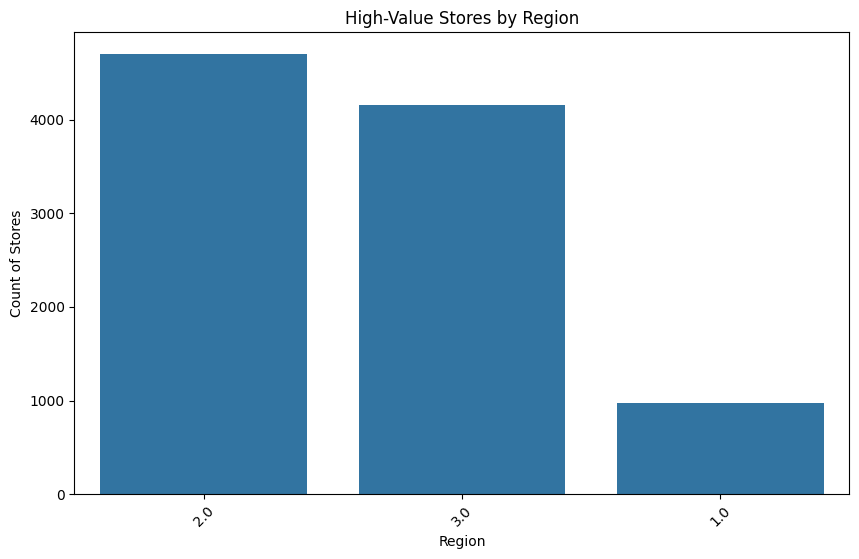

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=high_value_stores, x='Climate Code', order=high_value_stores['Climate Code'].value_counts().index)
plt.title("High-Value Stores by Region")
plt.xlabel("Region")
plt.ylabel("Count of Stores")
plt.xticks(rotation=45)
plt.show()

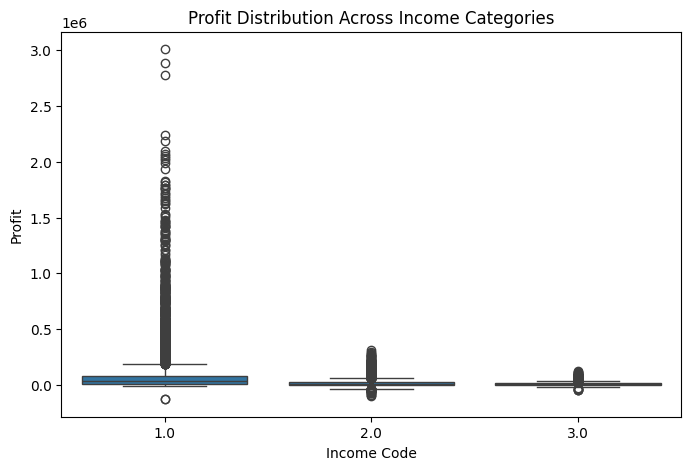

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='INCOME_CD', y='Profit', order=sorted(df['INCOME_CD'].unique()))
plt.title("Profit Distribution Across Income Categories")
plt.xlabel("Income Code")
plt.ylabel("Profit")
plt.show()

In [ ]:
print("Summary of High-Value Stores' Demographic Characteristics:")
high_value_summary

Summary of High-Value Stores' Demographic Characteristics:


,State Province,Market,Climate Code,Pharmacy_IND,Pickup_IND,SFS_IND,COMP_IND,College_STORE_IND,INCOME_CD,ETHNICITY_CD
count,9829,9829,9829.0,9829,9829,9829,9829,9829,9829.0,9829.0
unique,7,8,3.0,2,2,2,2,2,3.0,3.0
top,46,100,2.0,N,N,Y,N,Y,1.0,3.0
freq,4708,1875,4697.0,7685,7824,9104,5878,4973,5269.0,4671.0



**3) What targeted engagement and assortment strategies can be developed for each store cluster to maximize customer satisfaction and drive sales growth?**

With three clusters, targeted engagement and assortment strategies can be customized based on the characteristics of each cluster to maximize **customer satisfaction** and **sales growth**.

### **Cluster Profiles**
#### **Segment 1: Largest Cluster**  
this includes mainstream stores serving a wide variety of customers.

- **Characteristics**:
  - High volume but moderate profitability per store.
  - Likely located in areas with diverse demographics.
  - Balanced customer needs (essentials + convenience items).

- **Strategies**:
  1. **Assortment**:
     - Focus on high-demand, essential products across categories.
     - Offer regional favorites to cater to diverse tastes.
  2. **Engagement**:
     - Use loyalty programs to maintain broad appeal.
     - Introduce in-store promotions and discounts to retain footfall.
  3. **Marketing**:
     - Standardized advertising campaigns for general customer appeal.
     - Seasonal campaigns (e.g., holidays, back-to-school) for sales spikes.
  4. **Operational Enhancements**:
     - Optimize inventory levels using demand forecasting to reduce stockouts.


#### **Segment 3: Mid-Sized Cluster**  
It represents mid-tier stores likely in suburban or semi-urban areas.

- **Characteristics**:
  - Moderate sales and profitability.
  - Customer base with varied but predictable needs.
  - Could represent niche markets or focused customer groups.

- **Strategies**:
  1. **Assortment**:
     - Emphasize a mix of premium and mid-tier products.
     - Include local and specialty items to cater to specific community preferences.
  2. **Engagement**:
     - Leverage personalized promotions based on historical purchase data.
     - Host community events to strengthen the local connection.
  3. **Marketing**:
     - Focused campaigns highlighting specialty products or local relevance.
     - Partner with local influencers to promote the store brand.
  4. **Digital Integration**:
     - Encourage online orders and pickup via e-commerce tie-ins.


#### **Segment 0: Smallest Cluster**  
Represents niche or high-value stores with unique characteristics.

- **Characteristics**:
  - Smaller customer base but potentially higher profitability per store.
  - Located in affluent or niche areas with specific demands.
  - Higher potential for premium or luxury products.

- **Strategies**:
  1. **Assortment**:
     - Focus on premium, organic, and specialty products.
     - Rotate exclusive offerings to create a sense of novelty.
  2. **Engagement**:
     - Offer VIP loyalty programs or memberships.
     - Provide personalized customer service, such as store associates trained in high-value product recommendations.
  3. **Marketing**:
     - Highlight exclusivity and quality in marketing campaigns.
     - Use targeted social media ads to affluent customers.
  4. **In-Store Experience**:
     - Enhance the store ambiance with premium fixtures.
     - Introduce sampling events for luxury or new products.

In [ ]:
cluster_analysis = df.groupby('Segment').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Total_Units=('Units ', 'sum'),
    Dominant_Income=('INCOME_CD', lambda x: x.mode()[0] if len(x.mode()) > 0 else None),
    Dominant_Ethnicity=('ETHNICITY_CD', lambda x: x.mode()[0] if len(x.mode()) > 0 else None),
    Pharmacy_Stores_Count=('Pharmacy_IND', 'count'),
    Pickup_Stores_Count=('Pickup_IND', 'count'),
    College_Stores_Count=('College_STORE_IND', 'count')
).reset_index()

In [ ]:
cluster_analysis

,Segment,Total_Sales,Total_Profit,Total_Units,Dominant_Income,Dominant_Ethnicity,Pharmacy_Stores_Count,Pickup_Stores_Count,College_Stores_Count
0,0,2.552938e+09,9.685460e+08,49824285.0,1.0,3.0,5735,5735,5735
1,1,2.632237e+09,9.929282e+08,67991597.0,2.0,2.0,66431,66431,66431
2,3,9.403700e+08,3.533073e+08,24659157.0,2.0,1.0,26115,26115,26115


In [ ]:
cluster_analysis = df.groupby('Segment').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Total_Units=('Units ', 'sum'),
    Avg_Income=('INCOME_CD', 'mean'),
    Dominant_Ethnicity=('ETHNICITY_CD', lambda x: x.value_counts().idxmax()),
    Pharmacy_Stores=('Pharmacy_IND', 'sum'),
    Pickup_Stores=('Pickup_IND', 'sum'),
    College_Stores=('College_STORE_IND', 'sum')
).reset_index()

# Add percentage contribution to total sales and profit
total_sales = df['Sales'].sum()
total_profit = df['Profit'].sum()

cluster_analysis['Sales_Percent'] = (cluster_analysis['Total_Sales'] / total_sales) * 100
cluster_analysis['Profit_Percent'] = (cluster_analysis['Total_Profit'] / total_profit) * 100

# Display cluster-level insights
print(cluster_analysis)

# Analyze category-level performance within each cluster
category_performance = df.groupby(['Segment', 'Category']).agg(
    Total_Sales=('Sales', 'sum'),
    Total_Units=('Units ', 'sum'),
    Avg_Profit_Per_Unit=('Profit', lambda x: x.sum() / len(x))
).reset_index()

# Identify top-performing categories by sales in each segment
top_categories = category_performance.sort_values(by=['Segment', 'Total_Sales'], ascending=[True, False])

# Display top categories for each cluster
print(top_categories)

# Analyze locality and market-level characteristics
market_analysis = df.groupby(['Segment', 'Market']).agg(
    Total_Sales=('Sales', 'sum'),
    Total_Units=('Units ', 'sum')
).reset_index()

# Display market-level performance
print(market_analysis)